In [1]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Activation, Dropout, Flatten
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from typing import List
from pathlib import Path

In [2]:
# get the data
filename = 'dataset/emotions_dataset.csv'
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
df = pd.read_csv(filename, na_filter=False)

In [3]:
df_train = df[(df.usage == 'Training') | (df.usage == 'PublicTest')].copy().reset_index()
df_train['labels'] = [label_map[e] for e in df_train.emotion]

df_test = df[df.usage == 'PrivateTest'].copy().reset_index()
df_test['labels'] = [label_map[e] for e in df_test.emotion]
del df


In [4]:
def pixels_to_images(pixels_series: pd.Series) -> np.ndarray:
    pixels_lists = [[int(n) for n in p.split()] for p in pixels_series]
    X = np.array(pixels_lists) / 255
    X = X.reshape(-1, 48, 48, 1)
    return X

In [6]:
npy_data = 'dataset/numpy_images.npy'
if Path(npy_data).is_file():
    with open('dataset/numpy_images.npy', 'rb') as f:
        X = np.load(f)
else:
    X = pixels_to_images(df_train.pixels)
    with open('dataset/numpy_images.npy', 'wb') as f:
        np.save(f, X)

X_test = pixels_to_images(df_test.pixels)

Y = df_train.emotion.astype(int).to_list()
y_test = df_test.emotion.astype(int).to_list()

print(X.shape)

(32298, 48, 48, 1)


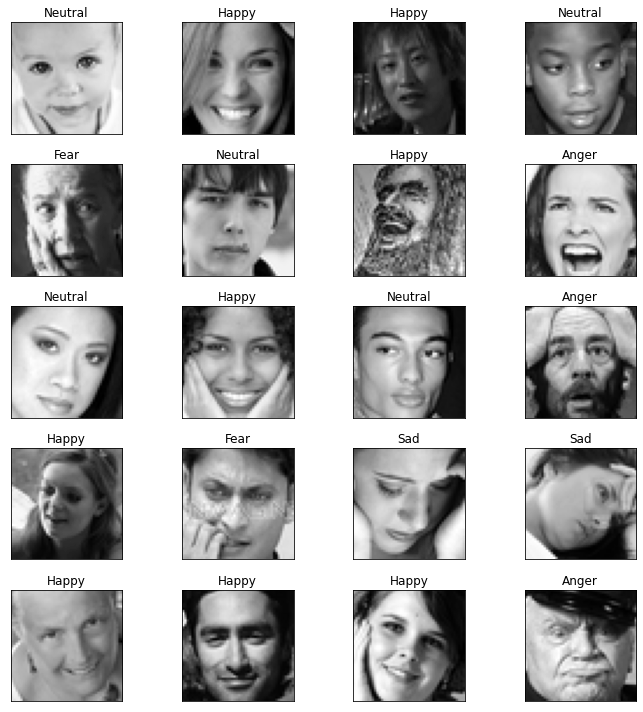

In [8]:
fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 5
true_labels = []
preds = []
for i in range(1, columns*rows +1):
    img_id = np.random.choice(X.shape[0])
    img = X[img_id, :, :, 0]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.xticks([], [])
    plt.yticks([], [])
    true_labels.append(df_train.labels.iloc[img_id])
    preds.append(true_labels[i-1])
    plt.title(f"{true_labels[i-1]}")
fig.tight_layout()
plt.show()

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=0)

In [10]:
X_train.shape

(29068, 48, 48, 1)

In [12]:
def my_model():
    model = Sequential()
    input_shape = (48,48,1)
    model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    optim = tf.keras.optimizers.Adam(learning_rate=2e-4)
    
    model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=optim)
    
    return model
model=my_model()
# model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [13]:
image_generator = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    zca_epsilon=1e-06,  # epsilon for ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,
    shear_range=0.1,  # set range for random shear
    zoom_range=0.0,  # set range for random zoom
    channel_shift_range=0.0,  # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode="nearest",
    cval=0.0,  # value used for fill_mode = "constant"
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format="channels_last",
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0,
)
image_generator = image_generator.flow(X_train, y_train, batch_size=64)

In [14]:
val_generator = ImageDataGenerator()
val_generator = val_generator.flow(X_val, y_val, batch_size=64)

In [15]:
path_model='checkpoints/{epoch:02d}-{val_loss:.6f}.hdf5'
Path('checkpoints').mkdir(parents=True, exist_ok=True)
h = model.fit(
    x=image_generator, 
    steps_per_epoch=len(X_train) // 64,
    epochs=100, 
    verbose=1, 
    validation_data=val_generator,
    shuffle=True,
    callbacks=[
        ModelCheckpoint(filepath=path_model),
        EarlyStopping(patience=15),
        ReduceLROnPlateau(patience=6, factor=0.3)
    ]
)

Epoch 1/100
454/454 [==============================] - 24s 53ms/step - loss: 1.7926 - acc: 0.3065 - val_loss: 1.8296 - val_acc: 0.3028
Epoch 2/100
454/454 [==============================] - 19s 43ms/step - loss: 1.5323 - acc: 0.4114 - val_loss: 1.4435 - val_acc: 0.4471
Epoch 3/100
454/454 [==============================] - 20s 43ms/step - loss: 1.3531 - acc: 0.4838 - val_loss: 1.2854 - val_acc: 0.5071
Epoch 4/100
454/454 [==============================] - 19s 43ms/step - loss: 1.2487 - acc: 0.5272 - val_loss: 1.2210 - val_acc: 0.5409
Epoch 5/100
454/454 [==============================] - 19s 43ms/step - loss: 1.1700 - acc: 0.5559 - val_loss: 1.1237 - val_acc: 0.5811
Epoch 6/100
454/454 [==============================] - 19s 43ms/step - loss: 1.1259 - acc: 0.5743 - val_loss: 1.1292 - val_acc: 0.5743
Epoch 7/100
454/454 [==============================] - 19s 43ms/step - loss: 1.0947 - acc: 0.5863 - val_loss: 1.1315 - val_acc: 0.5752
Epoch 8/100
454/454 [==============================] - 

In [16]:
scores = model.evaluate(X_test, y_test, verbose=1)

3589/3589 [==============================] - 1s 330us/sample - loss: 0.9383 - acc: 0.6840


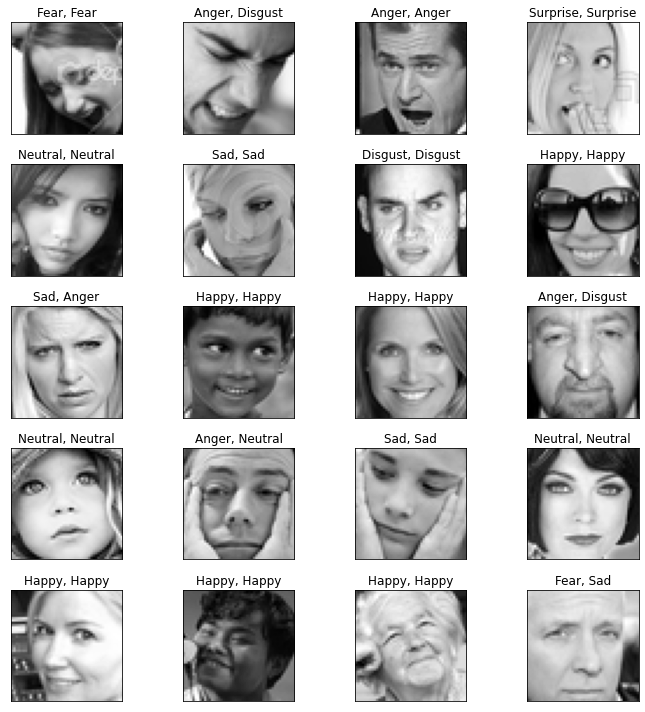

In [17]:
fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 5
true_labels = []
preds = []
preds = model.predict(X_test)
for i in range(1, columns*rows +1):
    img_id = np.random.choice(X_test.shape[0])
    img = X_test[img_id, :, :, 0]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title(f"{label_map[y_test[img_id]]}, {label_map[np.argmax(preds[img_id])]}")
fig.tight_layout()
plt.show()

In [ ]:
def emotion_analysis(emotions):
    y_pos = np.arange(len(label_map))
    plt.bar(y_pos, emotions, align='center', alpha=0.9)
    plt.tick_params(axis='x', which='both', pad=10,width=4,length=10)
    plt.xticks(y_pos, label_map)
    plt.ylabel('percentage')
    plt.title('emotion')
    
plt.show()

In [ ]:
y_pred=model.predict(X_test)
#print(y_pred)
y_test.shape

In [ ]:
#import seaborn as sn
#import pandas as pd
#import matplotlib.pyplot as plt
#import numpy as np
#from sklearn.metrics import confusion_matrix
#%matplotlib inline
#cm = confusion_matrix(np.where(y_test == 1)[1], y_pred)
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#df_cm = pd.DataFrame(cm, index = [i for i in "0123456"],
                  #columns = [i for i in "0123456"])
#plt.figure(figsize = (20,15))
#sn.heatmap(df_cm, annot=True)

**Real Time Expression Prediction**

In [ ]:
from skimage import io
img = image.load_img('../input/myimage/Shawon.jpg', grayscale=True, target_size=(48, 48))
show_img = image.load_img('../input/myimage/Shawon.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])
        

**Live Demo of Production Level Project**

[Facial Expression Detection Web App](https://faceai.herokuapp.com/)